




### Итоговый проект по курсу "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

**Наша задача в этом соревновании - предсказать цены на квартиры в датасете test.csv. \
Есть два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).** \


**Подключение библиотек и скриптов**

In [76]:
import datetime # для работы со времнем
import gc # сборщик мусора
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np 
import pandas as pd 
from pandas.plotting import scatter_matrix
from sklearn.model_selection import  KFold,  cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', 500)
np.random.seed(42)

## Шаг 1. Загрузка данных##

In [77]:
df = pd.read_csv('train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])


Строк в трейне: 10000
Строк в тесте 5000


**Посмотрим что из себя представляют данные.**

In [78]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


### 2. EDA ###

**Посмотрим из каки типов данных состоит датасет и есть ли пропуски.**

In [79]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
dtypes: 

**Сразу отмечаем что:**

 - есть пропуски в LifeSquare
 - есть пропуски в Healthcare_1   
 - большая часть полей типа float64, но так же есть поля типа int64 и object 
 

**Проделает эту же операцию для X_final**

In [80]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

**Тут тоже:**

 - есть пропуски в LifeSquare
 - есть пропуски в Healthcare_1   
 - большая часть полей типа float64, но так же есть поля типа int64 и object  

**Постмотрим на распределение значений величин в X**

array([[<AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>],
       [<AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>],
       [<AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>],
       [<AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>]],
      dtype=object)

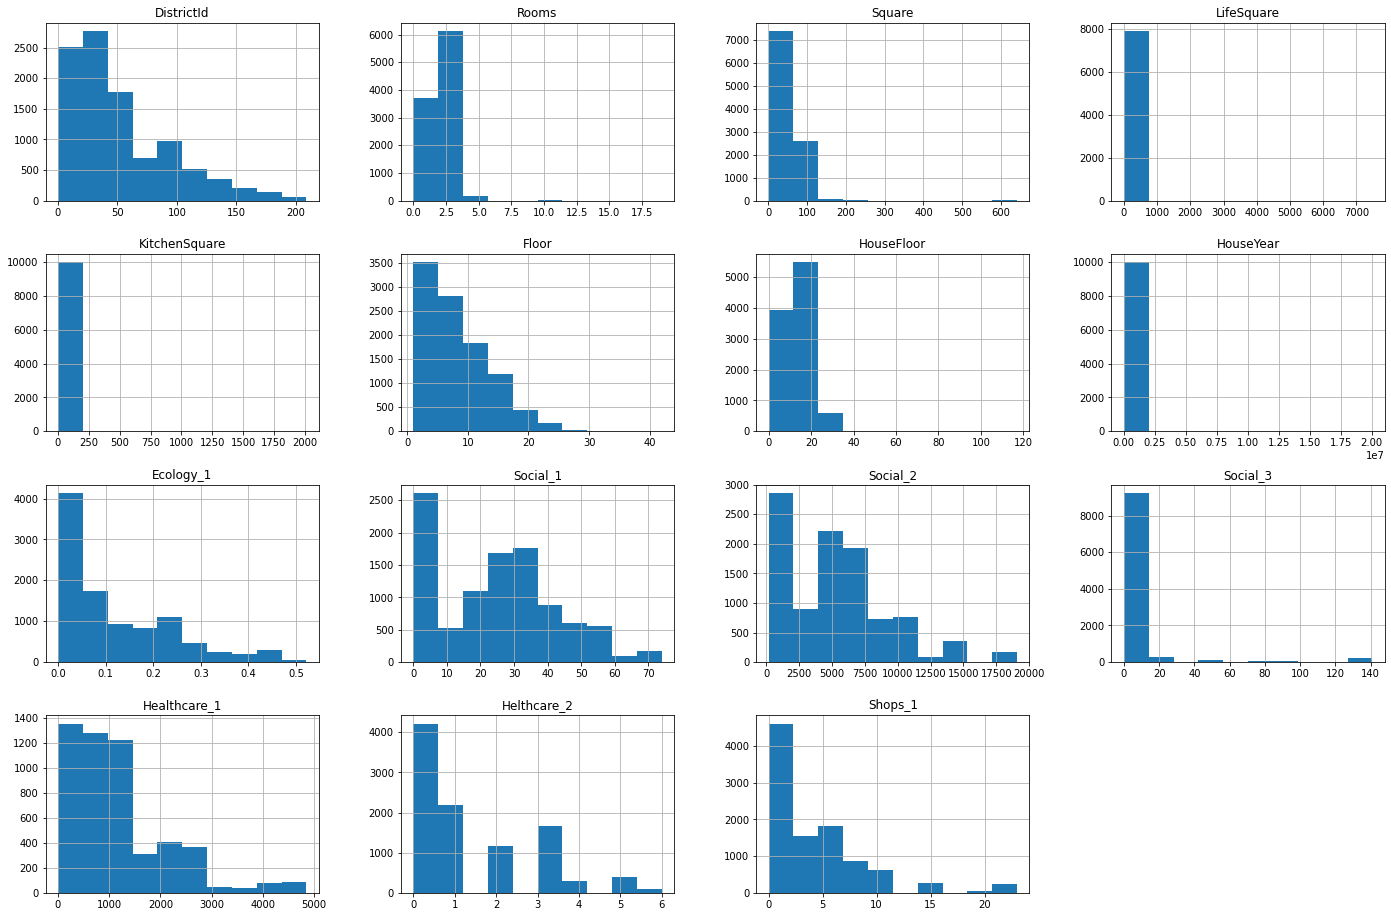

In [81]:
X.hist(figsize=(24,16))

**Сразу отмечаем что возможны выбросы в полях:**

 - HouseFloor     
 - HouseYear        
 - KitchenSquare
 - LifeSquare
 - Rooms          
 - Square

**Посмотрим на данные типа object**

In [82]:
X['Ecology_2'].value_counts().sort_values()

A      97
B    9903
Name: Ecology_2, dtype: int64

In [83]:
X['Ecology_3'].value_counts().sort_values()

A     275
B    9725
Name: Ecology_3, dtype: int64

In [84]:
X['Shops_2'].value_counts().sort_values()

A     825
B    9175
Name: Shops_2, dtype: int64

**Пока трудно сказать что то однозначное по поводу этих бинарных данных.**

### 3. Очистка данных и устранение пробелов. ###

**Посмотрим внимательней на Square, KitchenSquare и LifeSquare**

array([[<AxesSubplot:xlabel='Square', ylabel='Square'>,
        <AxesSubplot:xlabel='LifeSquare', ylabel='Square'>,
        <AxesSubplot:xlabel='KitchenSquare', ylabel='Square'>],
       [<AxesSubplot:xlabel='Square', ylabel='LifeSquare'>,
        <AxesSubplot:xlabel='LifeSquare', ylabel='LifeSquare'>,
        <AxesSubplot:xlabel='KitchenSquare', ylabel='LifeSquare'>],
       [<AxesSubplot:xlabel='Square', ylabel='KitchenSquare'>,
        <AxesSubplot:xlabel='LifeSquare', ylabel='KitchenSquare'>,
        <AxesSubplot:xlabel='KitchenSquare', ylabel='KitchenSquare'>]],
      dtype=object)

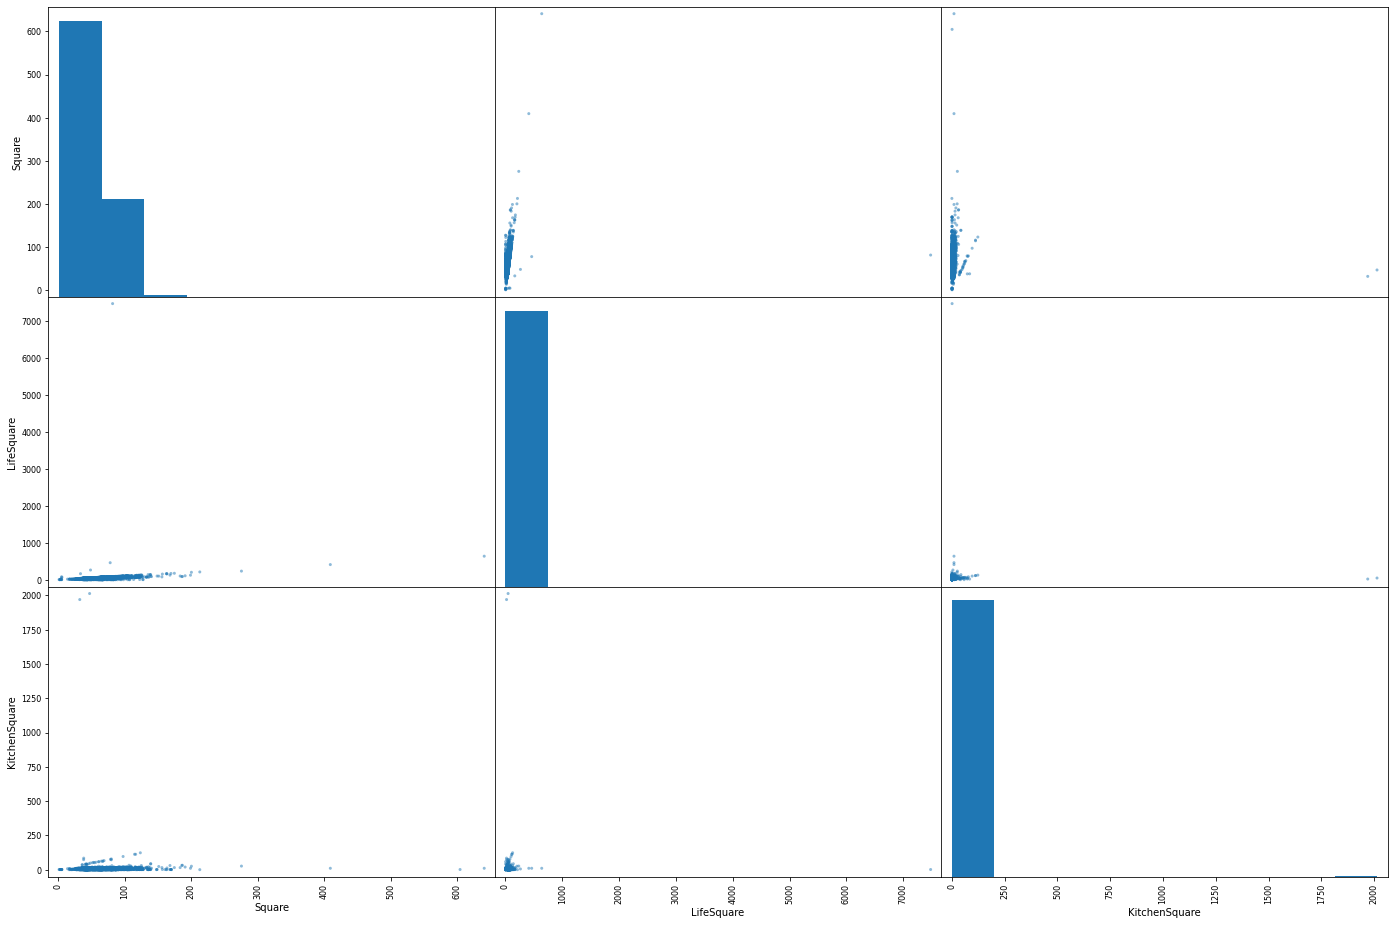

In [85]:
attributes=[
            'Square',
            'LifeSquare',
            'KitchenSquare'
            ]
scatter_matrix(X[attributes], figsize=(24,16))

**Выбросы очевидны. Откорректируем их(теряя при этом часть информации).**

array([[<AxesSubplot:xlabel='Square', ylabel='Square'>,
        <AxesSubplot:xlabel='LifeSquare', ylabel='Square'>,
        <AxesSubplot:xlabel='KitchenSquare', ylabel='Square'>],
       [<AxesSubplot:xlabel='Square', ylabel='LifeSquare'>,
        <AxesSubplot:xlabel='LifeSquare', ylabel='LifeSquare'>,
        <AxesSubplot:xlabel='KitchenSquare', ylabel='LifeSquare'>],
       [<AxesSubplot:xlabel='Square', ylabel='KitchenSquare'>,
        <AxesSubplot:xlabel='LifeSquare', ylabel='KitchenSquare'>,
        <AxesSubplot:xlabel='KitchenSquare', ylabel='KitchenSquare'>]],
      dtype=object)

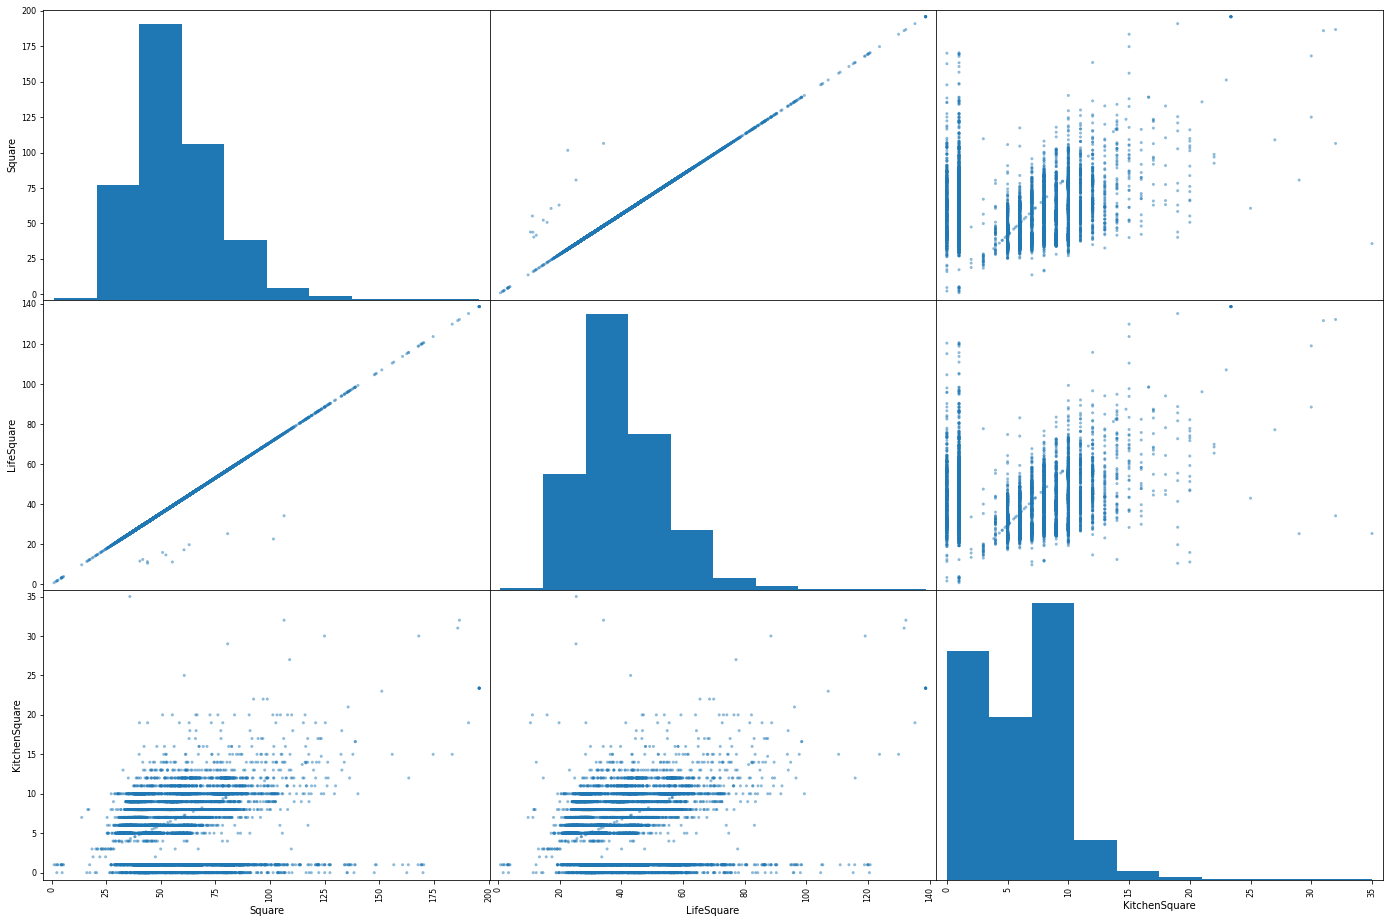

In [86]:
temporary_X=X.copy() 

Square_rate  = temporary_X['Square'].median()/ temporary_X['LifeSquare'].mean()
Kitchen_rate = temporary_X['Square'].median()/ temporary_X['KitchenSquare'].mean()


temporary_X.loc[temporary_X['Square'] >=195.75, 'Square'] = 195.75
temporary_X.loc[temporary_X['Square'] == 195.75, 'KitchenSquare'] = temporary_X['Square'] / (Kitchen_rate) 
temporary_X.loc[temporary_X['Square'] == 195.75, 'LifeSquare'] = temporary_X['Square'] / Square_rate
temporary_X.loc[temporary_X['KitchenSquare'] >35, 'KitchenSquare'] = temporary_X['Square'] / Kitchen_rate 

        
condition = (X['LifeSquare'].isna()) | (X['LifeSquare']>X['Square']*0.333)
        
temporary_X.loc[condition, 'LifeSquare'] = temporary_X.loc[condition, 'Square'] / Square_rate 
temporary_X.loc[temporary_X['LifeSquare'] <= 10, 'LifeSquare'] = temporary_X['Square'] / Square_rate
           
scatter_matrix(temporary_X[attributes], figsize=(24,16))

**Стало смотреться лучше.** 

<AxesSubplot:>

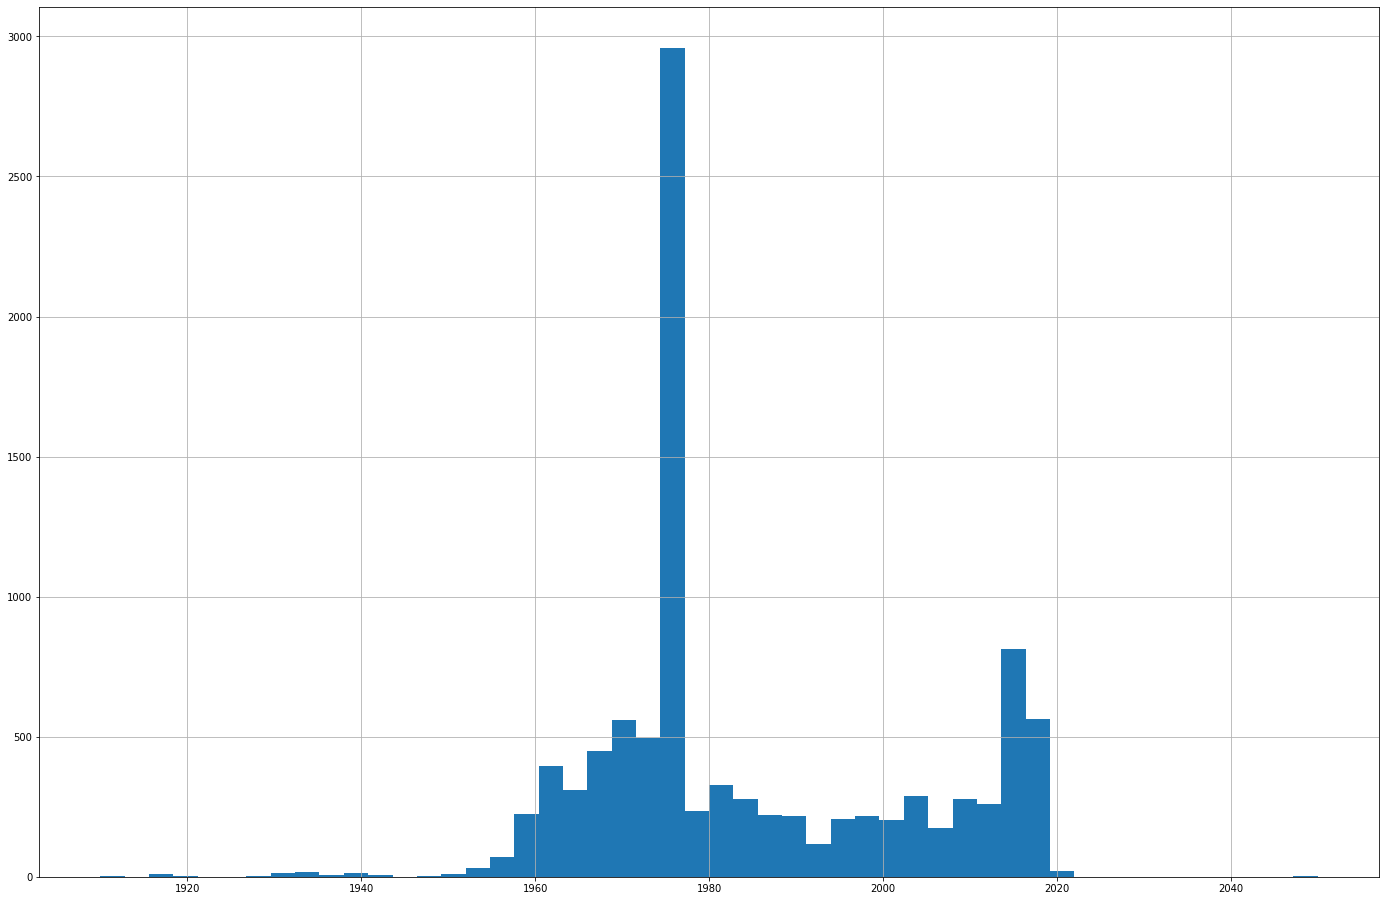

In [87]:
temporary_X.loc[temporary_X['HouseYear'] >2020,   'HouseYear'] = 2050
temporary_X['HouseYear'].hist(bins=50, figsize=(24,16))

1977 год - явный "выброс".

Оформим все эти и другие изменения в класс FeatureImputer

In [88]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        self.Square_rate  = None
        self.Kitchen_rate = None
        
            
    def fit(self, X):
        self.medians = X.median()
        self.Square_rate  = X['Square'].median()/ X['LifeSquare'].mean()
        self.Kitchen_rate = X['Square'].median()/ X['KitchenSquare'].mean()

         
    def transform(self, X, y=None):
        #Приведем к разумным значениям Square KitchenSquare KitchenSquare
        X.loc[X['Square'] >=195.75,   'Square'] = 195.75
        X.loc[X['Square'] == 195.75,  'KitchenSquare'] = X['Square'] / (self.Kitchen_rate) 
        X.loc[X['Square'] == 195.75,  'LifeSquare']    = X['Square'] / self.Square_rate
        X.loc[X['KitchenSquare'] >35, 'KitchenSquare'] = X['Square'] / self.Kitchen_rate 
                
        # Отметим аномалии и пропуски в данных LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        X.loc[X['LifeSquare'] <7, 'LifeSquare_nan'] = 2
        X.loc[X['LifeSquare'] > X['Square']*0.66, 'LifeSquare_nan'] = 3        
        X.loc[X['LifeSquare'] <=X['Square']*0.35 , 'LifeSquare_nan'] = 4
        X.loc[X['LifeSquare']>X['Square']*0.75 , 'LifeSquare_nan'] = 5
        
        # Отметим аномалии в данных KitchenSquare
        X['NO_KitchenSquare'] =0
        X.loc[X['KitchenSquare'] <=2 , 'NO_KitchenSquare'] = 1        
        
        #Приведем к разумным значениям Square
        X.loc[X['Square'] < 20, 'Square'] = 21
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        
        # Ещё раз откорректируем KitchenSquare
        X.loc[X['KitchenSquare'] >X['Square']*0.85 , 'KitchenSquare'] = X['Square'] / self.Kitchen_rate        
        X.loc[X['KitchenSquare'] <= 3, 'KitchenSquare'] = X['Square'] / (self.Kitchen_rate)        
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        #Обработаем поле HouseYear
        current_year = datetime.datetime.now().year      
        X['HouseYear_outlier'] = 0
        X.loc[(X['HouseYear'] > current_year) | (X['HouseYear'] == 1977) , 'HouseYear_outlier'] = 1
            
        #При Брежневе стройки социализма были велики... но не так как в этом датасете показывает 1977 год.
        #замена nan и 1977 на 2050 сработала хорошо
        X.loc[(X['HouseYear'] > current_year) | (X['HouseYear'] == 1977) , 'HouseYear'] = 2050
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # Ещё раз подправим LifeSquare           
        condition = (X['LifeSquare'].isna()) | (X['LifeSquare']>X['Square']*0.333)        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] / self.Square_rate 
        X.loc[X['LifeSquare'] <= 10, 'LifeSquare'] = X['Square'] / self.Square_rate

        
        return X, y


### 4. Feature engineering ###

In [89]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()

        if y is not None:
            
            #Идея создать поле отражающее значение средней цены квадратного метра в районе.           
            X['Price'] = y.values
            X['item_m2_price'] = X['Price']/X['Square']    
            mark = X.groupby(['DistrictId'], as_index=False).agg({'item_m2_price':'median'})
            self.DistrictId_mark = dict(mark.values)         
            X = X.drop('item_m2_price', axis=1)
            X = X.drop('Price', axis=1)
        
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df['item_m2_price'] = df['Price']/df['Square']    
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = 0           
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})

        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        

        ## Цена в зависимости от общей площади и от площади кухни
        if y is not None:
            df['Price'] = y.values
            df = self.FSqare_to_cat(df)
            df = self.Kitchen_to_cat(df)
            self.med_price_by_Kitcen_Fsqare = df.groupby(['kitch_cat', 'FS_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByKitchenFS'})
            
        ## Цена в зависимости от этажности дома
        if y is not None:
            df['Price'] = y.values
            df = self.Bfloor_to_cat(df)
            self.med_price_by_BFF = df.groupby(['B_floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByBFF'})
 
        ## Цена в зависимости от Ecol1_cat  
        if y is not None:
            df['Price'] = y.values
            df = self.Ecol1_to_cat(df)
            self.med_price_by_Eco1 = df.groupby(['Ecol1_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcol1'})
            
        ## Цена в зависимости от Social1_cat 
        if y is not None:
            df['Price'] = y.values
            df = self.Social1_to_cat(df)
            self.med_price_by_Social1 = df.groupby(['Social1_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial1'})
            
        ## Цена в зависимости от Social1_cat
        if y is not None:
            df['Price'] = y.values
            df = self.Social2_to_cat(df)
            self.med_price_by_Social2 = df.groupby(['Social2_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial2'})

        ## Цена в зависимости от Shop_cat
        if y is not None:
            df['Price'] = y.values
            df = self.Shop_to_cat(df)
            self.med_price_by_Shop = df.groupby(['Shop_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByShop'})

        ## Медианные значения Ecology_1 по районам.
        E1_mark = X.groupby(['DistrictId'], as_index=False).agg({'Ecology_1':'median'})        
        self.DistrictId_E1_mark = dict(E1_mark.values)
        
        ## Медианные значения Social_2 по районам.
        Social2_mark = X.groupby(['DistrictId'], as_index=False).agg({'Social_2':'median'})        
        self.DistrictId_Social2_mark = dict(Social2_mark.values)
        
        ## Медианные значения Shops_1 по районам.
        Shops_1_mark = X.groupby(['DistrictId'], as_index=False).agg({'Shops_1':'median'})        
        self.DistrictId_Shops_1_mark = dict(Shops_1_mark.values)
        
        ## Медианные значения Helthcare_2 по районам.        
        Healthcare_2_mark = X.groupby(['DistrictId'], as_index=False).agg({'Helthcare_2':'median'})        
        self.DistrictId_Healthcare_2_mark = dict(Healthcare_2_mark.values)
        
       
        
        #обнуление переменных для районов где статистика ничтожна
        for item in self.DistrictId_counts:
            if self.DistrictId_counts[item] == 0:
                self.DistrictId_Healthcare_2_mark[item] = 0
                self.DistrictId_Social2_mark[item] = 0
                self.DistrictId_E1_mark[item] = 0
                self.med_price_by_Kitcen_Fsqare[item] = 0
                self.med_price_by_BFF[item] = 0
                self.med_price_by_Eco1[item] = 0
                self.med_price_by_Social1[item] = 0
                self.DistrictId_Shops_1_mark[item] =0
                self.med_price_by_district[item] = 0
                self.med_price_by_floor_year[item] =0
                self.med_price_by_Social2[item] =0
                self.med_price_by_Shop[item] =0
                
        
        
    def transform(self, X):
        
        X['DistrictId_mark'] = X['DistrictId'].copy()
        X['DistrictId_mark'] = X['DistrictId'].map(self.DistrictId_mark)

        # DistrictId
        X['DistrictId_count']             = X['DistrictId'].map(self.DistrictId_counts) 
        X['DistrictId_E1_mark']           = X['DistrictId'].map(self.DistrictId_E1_mark)
        X['DistrictId_Social2_mark']      = X['DistrictId'].map(self.DistrictId_Social2_mark)
        X['DistrictId_Shops_1_mark']      = X['DistrictId'].map(self.DistrictId_Shops_1_mark)
        X['DistrictId_Healthcare_2_mark'] = X['DistrictId'].map(self.DistrictId_Healthcare_2_mark)
        
        
        
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers) 
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец flooar_cat
        X = self.year_to_cat(X)   # + столбец year_cat

        X = self.Kitchen_to_cat(X)  # + столбец Kitchen_to_cat
        X = self.FSqare_to_cat(X)   # + столбец FSqare_to_cat
        X = self.Bfloor_to_cat(X)   # + столбец Bfloor_to_cat
        X = self.Ecol1_to_cat(X)    # + столбец Ecol1_to_cat
        X = self.Social1_to_cat(X)  # + столбец Social1_to_cat
        X = self.Social2_to_cat(X)  # + столбец Social2_to_cat
        X = self.Shop_to_cat(X)     # + столбец Shop_to_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.med_price_by_Kitcen_Fsqare is not None:
            X = X.merge(self.med_price_by_Kitcen_Fsqare, on=['kitch_cat', 'FS_cat'], how='left')
            
        if self.med_price_by_BFF is not None:
            X = X.merge(self.med_price_by_BFF, on=['B_floor_cat'], how='left')
        if self.med_price_by_Eco1 is not None:
            X = X.merge(self.med_price_by_Eco1, on=['Ecol1_cat'], how='left')
        if self.med_price_by_Social1 is not None:
            X = X.merge(self.med_price_by_Social1, on=['Social1_cat'], how='left')
        if self.med_price_by_Social2 is not None:
            X = X.merge(self.med_price_by_Social2, on=['Social2_cat'], how='left')
        if self.med_price_by_Shop is not None:
            X = X.merge(self.med_price_by_Shop, on=['Shop_cat'], how='left')
            
            
        #переменные характеризующие районы по медианному значению    
        X.loc[X['MedPriceByDistrict'].isna(), 'MedPriceByDistrict'] = X['MedPriceByDistrict'].median()
        X.loc[X['MedPriceByFloorYear'].isna(), 'MedPriceByFloorYear'] = X['MedPriceByFloorYear'].median()
        
        X.loc[X['DistrictId_mark'].isna(), 'DistrictId_mark'] = X['DistrictId_mark'].median()       
        X.loc[X['DistrictId_E1_mark'].isna(), 'DistrictId_E1_mark'] = X['DistrictId_E1_mark'].median()
        X.loc[X['DistrictId_Social2_mark'].isna(), 'DistrictId_Social2_mark'] = X['DistrictId_Social2_mark'].median()
        X.loc[X['DistrictId_Healthcare_2_mark'].isna(), 'DistrictId_Healthcare_2_mark'] = X['DistrictId_Healthcare_2_mark'].median()
        
        X.loc[X['MedPriceByKitchenFS'].isna(), 'MedPriceByKitchenFS'] = X['MedPriceByKitchenFS'].median()
        X.loc[X['MedPriceByShop'].isna(), 'MedPriceByShop'] = 0

        return X
    
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        #Пороговые значения выбирались при изучении распределения целевой величины на гистограмме 
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
        
        return X
    
    

    @staticmethod
    def Bfloor_to_cat(X):
        
        X['B_floor_cat'] = np.nan
        #Пороговые значения выбирались при изучении распределения целевой величины на гистограмме 
        X.loc[X['HouseFloor'] < 5, 'B_floor_cat'] = 1  
        X.loc[(X['HouseFloor'] >= 5) & (X['HouseFloor'] < 9), 'B_floor_cat'] = 2
        X.loc[(X['HouseFloor'] >= 9) & (X['HouseFloor'] <= 13), 'B_floor_cat'] = 3
        X.loc[(X['HouseFloor'] > 13) & (X['HouseFloor'] <= 16), 'B_floor_cat'] = 4
        X.loc[(X['HouseFloor'] > 16) & (X['HouseFloor'] <= 21), 'B_floor_cat'] = 5
        X.loc[X['HouseFloor'] > 21, 'B_floor_cat'] = 6
        
        return X


    @staticmethod
    def Social1_to_cat(X):
        
        X['Social1_cat'] = np.nan
        #Пороговые значения выбирались при изучении распределения целевой величины на гистограмме 
        X.loc[X['Social_1'] < 11.5, 'Social1_cat'] = 1  
        X.loc[(X['Social_1'] >= 11.5) & (X['Social_1'] < 28.4), 'Social1_cat'] = 2
        X.loc[(X['Social_1'] >= 26.4) & (X['Social_1'] <= 40), 'Social1_cat'] = 3
        X.loc[(X['Social_1'] > 40) & (X['Social_1'] <= 55), 'Social1_cat'] = 4
        X.loc[X['Social_1'] > 55, 'Social1_cat'] = 5
       
        return X


    @staticmethod
    def Social2_to_cat(X):
        
        X['Social2_cat'] = np.nan
        #Пороговые значения выбирались при изучении распределения целевой величины на гистограмме 
        X.loc[X['Social_2'] < 4200, 'Social2_cat'] = 1  
        X.loc[(X['Social_2'] >= 4200) & (X['Social_2'] < 9000), 'Social2_cat'] = 2
        X.loc[X['Social_2'] > 9000, 'Social2_cat'] = 3
       
        return X

    @staticmethod
    def Shop_to_cat(X):
        
        X['Shop_cat'] = np.nan
        #Пороговые значения выбирались при изучении распределения целевой величины на гистограмме 
        X.loc[X['Shops_1'] < 8, 'Shop_cat'] = 1  
        X.loc[X['Shops_1'] > 8, 'Shop_cat'] = 2
       
        return X
    
    
    
    @staticmethod
    def Ecol1_to_cat(X):
        
        X['Ecol1_cat'] = np.nan
        #Пороговые значения выбирались при изучении распределения целевой величины на гистограмме 
        X.loc[X['Ecology_1'] < 0.1, 'Ecol1_cat'] = 1  
        X.loc[X['Ecology_1'] > 0.1, 'Ecol1_cat'] = 2
       
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        #Пороговые значения выбирались при изучении распределения целевой величины на гистограмме 
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

        return X

    @staticmethod
    def Kitchen_to_cat(X):
        
        X['kitch_cat'] = np.nan
        #Пороговые значения выбирались при изучении распределения целевой величины на гистограмме 
        X.loc[X['KitchenSquare'] <= 4.35, 'kitch_cat'] = 1
        X.loc[(X['KitchenSquare'] > 4.35) & (X['KitchenSquare'] <= 5.8), 'kitch_cat'] = 2
        X.loc[(X['KitchenSquare'] > 5.8) & (X['KitchenSquare'] <= 6.7), 'kitch_cat'] = 3
        X.loc[(X['KitchenSquare'] > 6.7) & (X['KitchenSquare'] <= 7.3), 'kitch_cat'] = 4      
        X.loc[(X['KitchenSquare'] > 7.3) & (X['KitchenSquare'] <= 8.5), 'kitch_cat'] = 5      
        X.loc[(X['KitchenSquare'] > 8.5) & (X['KitchenSquare'] <= 9.5), 'kitch_cat'] = 6      
        X.loc[(X['KitchenSquare'] > 9.5) & (X['KitchenSquare'] <= 10.8), 'kitch_cat'] = 7      
        X.loc[(X['KitchenSquare'] > 10.8) & (X['KitchenSquare'] <= 11.6), 'kitch_cat'] = 8      
        X.loc[(X['KitchenSquare'] > 11.6) & (X['KitchenSquare'] <= 12.5), 'kitch_cat'] = 9      
        X.loc[(X['KitchenSquare'] > 12.5), 'kitch_cat'] = 10
        
        return X

    @staticmethod
    def FSqare_to_cat(X):
        
        X['FS_cat'] = np.nan
        #Пороговые значения выбирались при изучении распределения целевой величины на гистограмме 
        X.loc[X['Square'] < 25, 'FS_cat'] = 1
        X.loc[(X['Square'] >= 25) & (X['Square'] <= 50), 'FS_cat'] = 2
        X.loc[(X['Square'] > 50) & (X['Square'] <= 58.5), 'FS_cat'] = 3
        X.loc[(X['Square'] > 58.5) & (X['Square'] <= 70.5), 'FS_cat'] = 4
        X.loc[(X['Square'] > 70.5) & (X['Square'] <= 94), 'FS_cat'] = 5
        X.loc[(X['Square'] >= 94) & (X['Square'] <= 112), 'FS_cat'] = 6
        X.loc[(X['Square'] > 112), 'FS_cat'] = 7
            
        return X


### 5. Модель ###


C:\Users\999\AppData\Local\Temp/ipykernel_17048/2350377269.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.medians = X.median()


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


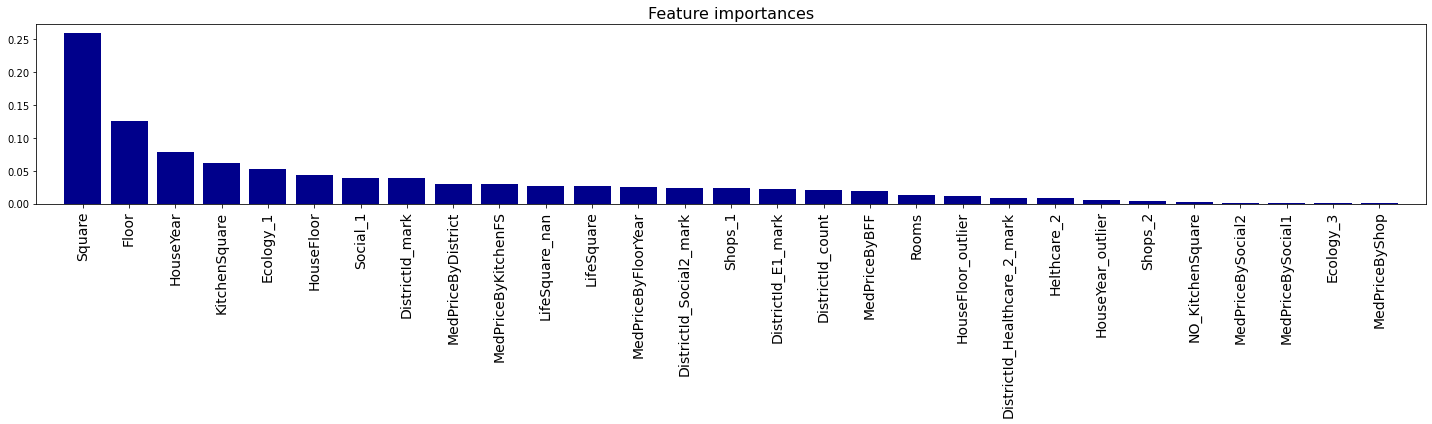

      Id          Price
0    725  157065.242744
1  15856  218725.216754
2   5480  247601.394661
3  15664  319683.320164
4  14275  150970.735980
(5000, 2)


In [90]:

df = pd.read_csv('train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]


imputer = FeatureImputer()
imputer.fit(X)
X, y = imputer.transform(X, y)
features = FeatureGenetator()
features.fit(X, y)
X = features.transform(X)
X = X.drop('Id', axis=1)
remain_features = ['Rooms', 
                   'Square', 
                   'LifeSquare', 
                   'KitchenSquare', 
                   'Floor', 
                   'Ecology_1', 
                   'Social_1', 
                   'Shops_1',
                   'HouseFloor_outlier', 
                   'HouseYear_outlier', 
                   'LifeSquare_nan',
                   'HouseFloor', 
                   'HouseYear',
                   'DistrictId_mark',
                   'DistrictId_E1_mark', 
                   'DistrictId_Social2_mark', 
                   'DistrictId_Healthcare_2_mark', 
                   'Helthcare_2', 
                   'MedPriceByKitchenFS',
                   'MedPriceByBFF',
                   'MedPriceBySocial1',
                   'MedPriceBySocial2',
                   'MedPriceByShop',
                   'NO_KitchenSquare',
                   'DistrictId_count',  
                   'Ecology_3', 
                   'Shops_2',
                   'MedPriceByDistrict',
                   'MedPriceByFloorYear']

X = X[remain_features]
X_final, _= imputer.transform(X_final)
X_final = features.transform(X_final)
X_final = X_final[remain_features]

model = LGBMRegressor( boosting = 'goss', objective='regression_l1', num_leaves = 45000, max_depth=-950000, learning_rate=0.01,
                             min_samples_leaf=4,
                             n_estimators=10000,
                             random_state=42)






# Обучаю модель на всем трейне
model.fit(X, y)

def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)



y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions2.csv', index=False)

print(preds_final.head())




print(preds_final.shape)

